<a href="https://colab.research.google.com/github/tejeshk05/track_and_count_vehicles/blob/main/track_and_count_vehicles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/2.mp4"

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.28 ðŸš€ Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete âœ… (2 CPUs, 12.7 GB RAM, 30.0/78.2 GB disk)


In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.20.0


In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 131M/131M [00:00<00:00, 324MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [ ]:
import supervision as sv
import numpy as np

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


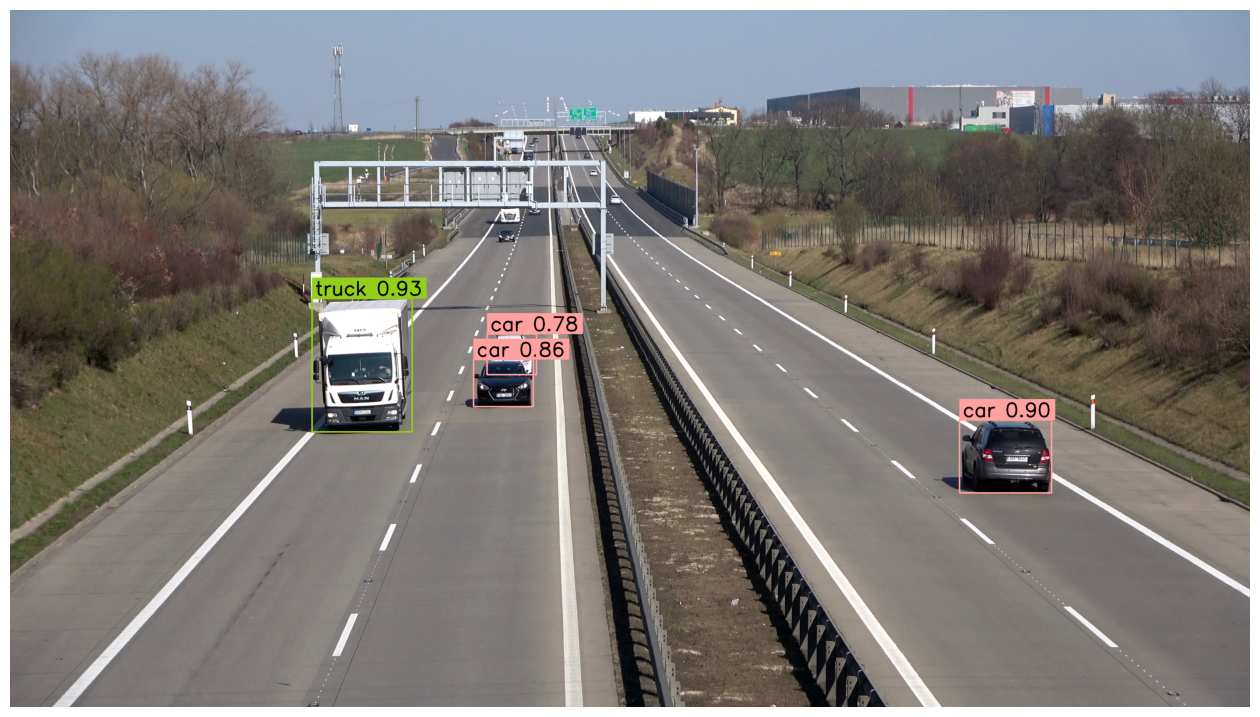

In [ ]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [ ]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-2-counting-result-with-counter.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
Supe